In [1]:
import numpy as np

from utils.loadData import loadDataWithNews
from lstm.preprocessing import dataToTimeSeriesMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadDataWithNews()

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
features.head()

,Open,High,Low,Close,Volume,positive,neutral,negative
0,21308.351563,23642.660156,21234.675781,22805.162109,71378606374,2,3,0
1,22806.796875,23238.601563,22399.812500,23137.960938,40387896275,3,2,0
2,23132.865234,24085.855469,22826.472656,23869.832031,38487546580,0,1,0
3,23861.765625,24209.660156,23147.710938,23477.294922,37844228422,1,2,0
4,23474.455078,24059.982422,22159.367188,22803.082031,45852713981,3,3,0


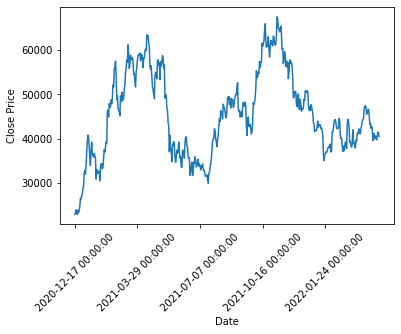

In [4]:
normalized_data, scaler = normalizeAtOnce(features.iloc[:,:-3])
normalized_data = np.concatenate([normalized_data, features.iloc[:,-3:]], axis=1)
show_data_simple(features["Close"], df["Date"])

2022-04-22 12:07:16.786495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


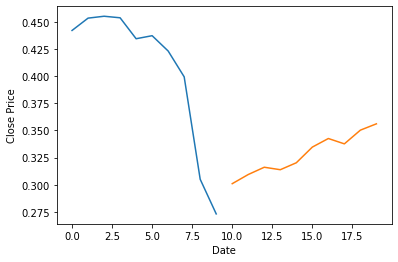

Input shape: (40, 10, 8)
Target shape: (40,)


In [5]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 64,
    "epochs": 20,
    "features": normalized_data.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 3], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [6]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 50)            11800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 32,510
Trainable params: 32,510
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 0.2231 - rmse: 0.4724 
Epoch 1: val_loss improved from inf to 0.02491, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 4s 203ms/step - loss: 0.2129 - rmse: 0.4615 - val_loss: 0.0249 - val_rmse: 0.1578
Epoch 2/20
4/6 [===================>..........] - ETA: 0s - loss: 0.0973 - rmse: 0.3119
Epoch 2: val_loss did not improve from 0.02491
6/6 [==============================] - 0s 30ms/step - loss: 0.0908 - rmse: 0.3013 - val_loss: 0.0459 - val_rmse: 0.2143
Epoch 3/20
5/6 [========================>.....] - ETA: 0s - loss: 0.0662 - rmse: 0.2572
Epoch 3: val_loss did not improve from 0.02491
6/6 [==============================] - 0s 33ms/step - loss: 0.0592 - rmse: 0.2434 - val_loss: 0.0873 - val_rmse: 0.2955
Epoch 4/20
4/6 [===================>..........] - ETA: 0s - loss: 0.0663 - rmse: 0.2576
Epoch 4: val_loss did not improve from 0.02491
6/6 [==============================] - 0s 45ms/st

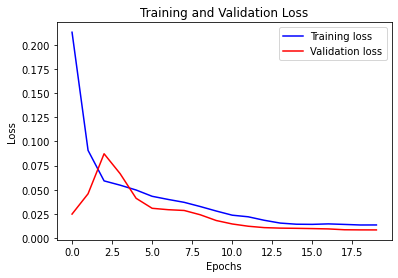

In [7]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [8]:
x, y = dataToTimeSeriesMultiDimensional(x_test, y_test[:,3], config["past"], config["future"])

In [9]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 1s 800ms/step - loss: 0.0101 - rmse: 0.1005
---- TEST RESULTS ----
MSE loss - 0.010091343894600868
RMSE - 0.10045567899942398


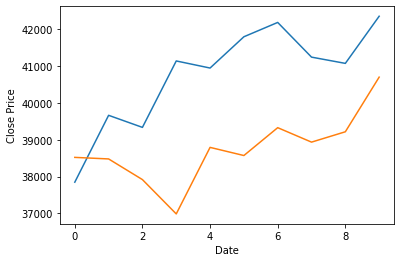

In [10]:
showRegressionExampleMultiDimensional(x[0], y[0], model, scaler, withNews=True)

In [11]:
evaluateFinal(getModel, dataset_train, dataset_val, config, "regression_with_news")

Training Started...
Iterations:
1
2
3
4
5
6
7
8
9
10
Done
